# Interactive tag analysis

Requisites to run this notebook:
- apriltag C library compiled (see README.md)
- python scripts installed in `../python` (can change it manually in cell 4)
- all results saved to `./data/` (excluded from version control)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%matplotlib qt
%matplotlib inline

In [38]:
import sys, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cv2  # Used to read images from video file
import skimage.io

mpl.rcParams['image.cmap'] = 'gray'

In [4]:
import sys
#pythondir="/Users/megret/Documents/Research/BeeTracking/Soft/apriltag/swatbotics-apriltag/python"
pythondir=os.path.join(os.getcwd(), '../python')
sys.path.append(pythondir)

In [10]:
import apriltagdetect as atd
from collections import OrderedDict
import math

# Loading of tag images from file and display

In [202]:
# Extract tag images from json files and put them in a flat table
# (extracted_tag works only if `tag_img` field was saved in the file)
# FIRST NEED TO EXTRACT TAGS TO FILES

import json

frames = np.r_[range(9239,9269),range(8359,8389)]

tagimgs = []
print('Loading from file...')
for frame in frames:
    print("{}, ".format(frame), end='')
    with open('data/C02_170622120000-tags/tags-{}.json'.format(frame),'r') as fp:
        mftags = json.load(fp, object_pairs_hook=lambda a: OrderedDict(a))
        mfdata = mftags['data']
        tags2 = mfdata[str(frame)]['tags']  # Select only tags from first frame
        for tag in tags2:
            tagimgs.append({'frame':frame, 'id':tag['id'], 'tagimg':atd.b64_to_img(tag['tag_img'])})
print('Done.')

Loading from file...
9239, 9240, 9241, 9242, 9243, 9244, 9245, 9246, 9247, 9248, 9249, 9250, 9251, 9252, 9253, 9254, 9255, 9256, 9257, 9258, 9259, 9260, 9261, 9262, 9263, 9264, 9265, 9266, 9267, 9268, 8359, 8360, 8361, 8362, 8363, 8364, 8365, 8366, 8367, 8368, 8369, 8370, 8371, 8372, 8373, 8374, 8375, 8376, 8377, 8378, 8379, 8380, 8381, 8382, 8383, 8384, 8385, 8386, 8387, 8388, Done.


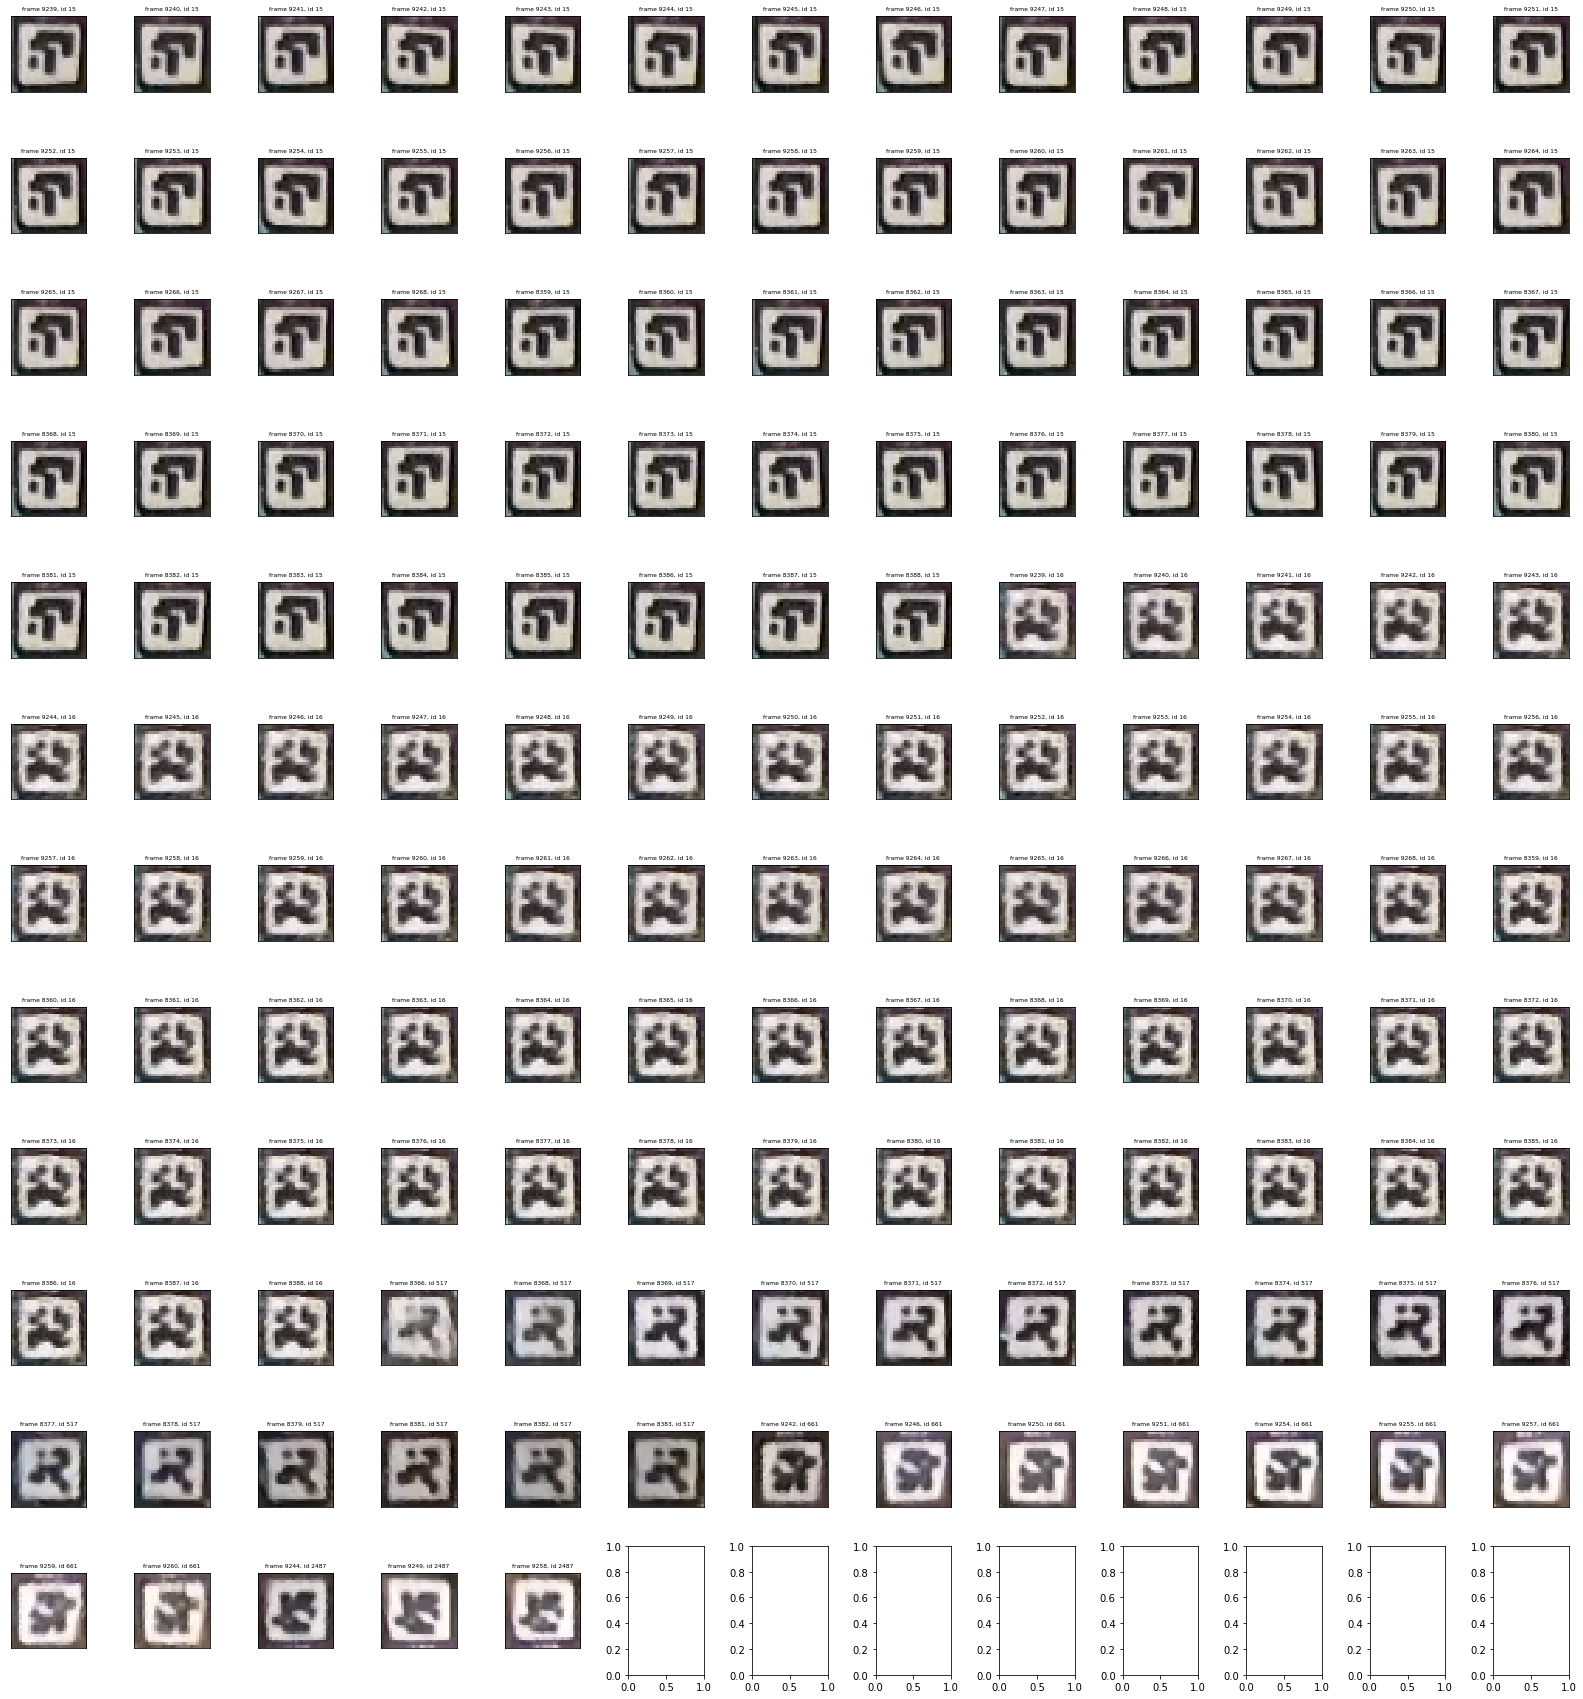

In [203]:
#tagf = [tag for tag in tagimgs if tag['id']==15]

tagf = sorted(tagimgs, key=lambda tag:tag['id'])

def show_tags(tags, label_template='frame {frame}, id {id}'):
    nx = math.ceil(math.sqrt(len(tags)))
    ny = math.ceil(len(tags)/nx)
    
    fig,ax=plt.subplots(ny,nx, figsize=(1.7*nx,2*ny))
    axf=ax.ravel()
    for k,tag in enumerate(tags):
        plt.sca(axf[k])
        plt.imshow(tag['tagimg'])
        plt.title(label_template.format(**tag),
                 {'fontsize': 6})
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    
show_tags(tagf)

Load reference templates from `data/tag25h5inv/png/*`

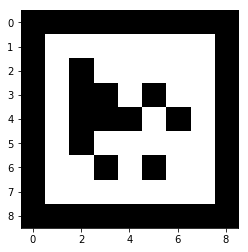

In [49]:
def load_tag_template(id, file_template="data/tag25h5inv/png/keyed{id:04}.png"):
    filename=file_template.format(id=id)
    A=skimage.io.imread(filename)
    I = np.zeros(np.array(A.shape[0:2])+np.array([2,2]))
    I[1:-1,1:-1]=A[:,:]
    return I
    
tagimg=load_tag_template(0)
#print(tagimg)
plt.imshow(tagimg)

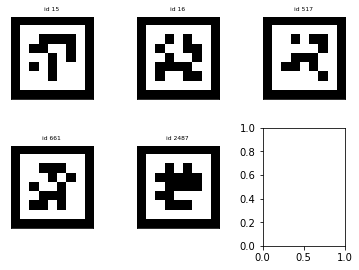

In [96]:
refids = np.unique([tag['id'] for tag in tagf])
reftags = [{'id':id, 'tagimg':load_tag_template(id)} for id in refids]

show_tags(reftags, label_template='id {id}')

# Exploration of tag image feature space, Dimensionality reduction

(148, 729)
(5, 729)


Text(0,0.5,'sample')

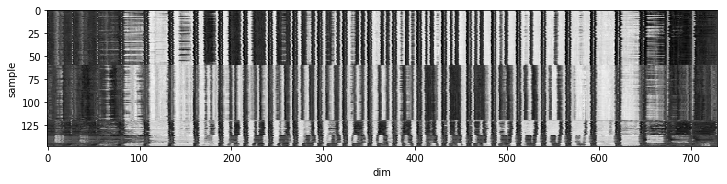

In [115]:
import skimage.transform
from skimage.filters import gaussian

shape=prep(tagf[0]).shape

def prep(tag):
#    return np.sum(tag['tagimg'][1::3,1::3],axis=2)
    return np.sum(np.atleast_3d(tag['tagimg']),axis=2)

def prepref(tag):
    #return skimage.transform.resize(tag['tagimg'],shape[0:2],order=0, mode='reflect')
    I=skimage.transform.resize(tag['tagimg'],shape[0:2],order=0, mode='reflect')
    I=gaussian(I,sigma=1)
    return I


xlr = np.array( [np.nonzero(refids==tag['id'])[0] for tag in tagf] ).ravel()
tagmat = np.array( [prep(tag).ravel() for tag in tagf] )
#tagmat = np.r_[np.array([prep(tag).ravel() for tag in tagf]),
#               np.array([np.rot90(prep(tag)).ravel() for tag in tagf]), # Add rotated versions
#               np.array([np.rot90(prep(tag),2).ravel() for tag in tagf]),
#               np.array([np.rot90(prep(tag),3).ravel() for tag in tagf])]

refmat = np.array( [prepref(tag).ravel() for tag in reftags] )

print(tagmat.shape)
print(refmat.shape)

# Normalize
tagmat = tagmat / np.sqrt(np.sum(tagmat ** 2, axis=1, keepdims=True))
refmat = refmat / np.sqrt(np.sum(refmat ** 2, axis=1, keepdims=True))

plt.figure(figsize=(12,4))
plt.imshow(tagmat, cmap='gray')
plt.xlabel('dim')
plt.ylabel('sample')

In [147]:
import sklearn
from sklearn.manifold.t_sne import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import LocallyLinearEmbedding, Isomap

dimred = PCA(n_components=3)
#dimred = LocallyLinearEmbedding(n_components=2)
#dimred = Isomap(n_components=2, n_neighbors=20)

dimred.fit(tagmat)
#dimred.fit(refmat)

dims=slice(1,3)

X = dimred.transform(tagmat)
xx = X[:,dims]

print(xx.shape)

X2 = dimred.transform(refmat)
x2 = X2[:,dims]


(148, 2)


[-0.08316387  0.24228604 -0.21262259  0.27934161] 0.0162724959632


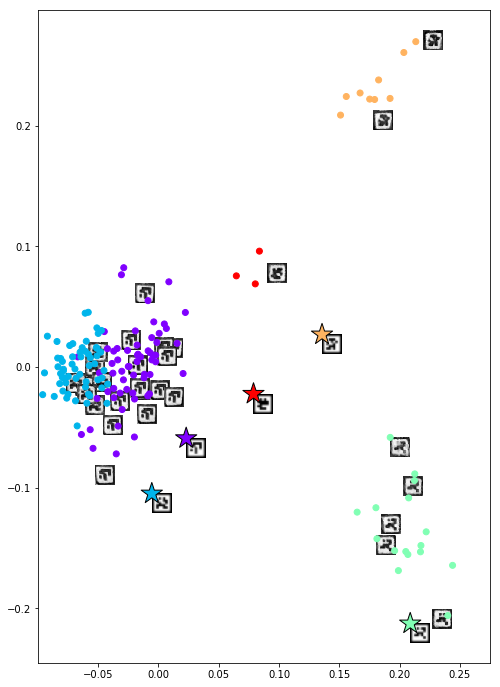

In [148]:
#tsne = TSNE(perplexity=5, early_exaggeration=1)
#xx = tsne.fit_transform(xx)
#print(xx.shape)

import pandas as pd
def sample_ids(tagmat, N):
    clustering = AgglomerativeClustering(n_clusters=N)
    c = clustering.fit(tagmat)

    L=pd.DataFrame(data={'id':np.arange(len(c.labels_)),'c':c.labels_})
    ids=L.groupby('c').first()
    ids=ids.get_values()
    return ids.ravel()

ids = sample_ids(tagmat, 30)
#ids=range(0,len(tagf), 10)
#ids=[]

def extent2d(xx):
    return np.array([np.min(xx[:,0]),np.max(xx[:,0]),np.min(xx[:,1]),np.max(xx[:,1])])
def extentunion(e1,e2):
    return np.array([min(e1[0],e2[0]),max(e1[1],e2[1]),min(e1[2],e2[2]),max(e1[3],e2[3])])

extent=extentunion( extent2d(xx), extent2d(x2) )
s=(extent[1]-extent[0])/20
print(extent,s)
fig = plt.figure(figsize=(12,12))
xxn=xx+np.random.randn(*xx.shape)*0.01
plt.scatter(xxn[:,0],xxn[:,1],c=xlr,cmap='rainbow')
plt.scatter(x2[:,0],x2[:,1],s=500,marker='*',c=range(len(refids)),cmap='rainbow',
           edgecolor='black')
for k in ids:
    plt.imshow(tagmat[k].reshape(shape),extent=xx[k,[0,0,1,1]]+[0,s,-s,0],cmap='gray')
for k,_ in enumerate(refids):
    plt.imshow(refmat[k].reshape(shape),extent=x2[k,[0,0,1,1]]+[0,s,-s,0],cmap='gray')
plt.axis((extent+np.array([-s,2*s,-2*s,s])));

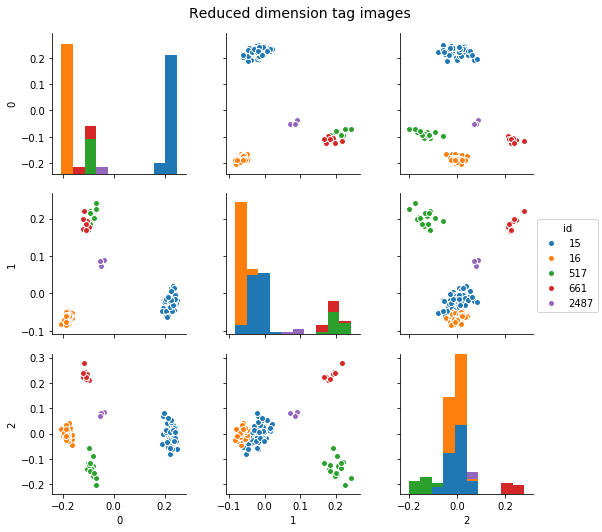

In [173]:
import seaborn as sns

dfx = pd.DataFrame(X)
dfx['class'] = xlr
dfx['id'] = refids[xlr]

# Scatter Plot with Hue for visualizing data in 3-D
pp = sns.pairplot(dfx, hue='id', vars=range(3) )
fig = pp.fig
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Reduced dimension tag images', fontsize=14)

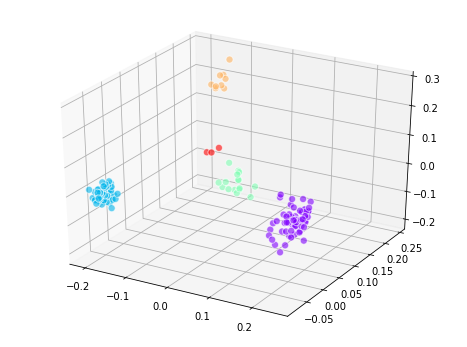

In [177]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], s=50, alpha=0.6, c=xlr, cmap='rainbow', edgecolors='w')

In [198]:
import ipyvolume as ipv
fig=ipv.figure()
ipv.scatter(X[:,0], X[:,1], X[:,2], size=4, marker="sphere", color=plt.cm.rainbow(xlr/np.max(xlr)))
ipv.xlim(np.min(X[:,0]),np.max(X[:,0]))
ipv.ylim(np.min(X[:,0]),np.max(X[:,0]))
ipv.zlim(np.min(X[:,0]),np.max(X[:,0]))
ipv.show()
fig.camera_control = 'orbit' # Bug: come back to trackball after first interaction?